## mpi manager - granularity plugin


- *Steps*
    1. Import Scanflow and check the local environment
    2. Create Scanflow environment for mpiworkloads (namespace, agents)
    3. ****[RUN MPI Workloads]****
        1. exp1
        2. exp2
        3. exp3
    6. Clean environment

## Steps
### Step1: Import Scanflow and check the local environment
1. import scanflow
    - For defining and building scanflow application, we need to import ScanflowClient
    - For deploying scanflow application, we need to import ScanflowDeployerClient
2. check local environment
    - For deploying scanflow application
        - If user starts the notebook at local and has the privilege to submit object on Kubernetes. We don't need to configure "SCANFLOW_SERVER_URI"
        - If user starts the notebook inside Kubernetes pod, or the local user does not have privilege to connect Kubernetes. We need to configure "SCANFLOW_SERVER_URI"
    - For saving deliverables, we need to configure url of Scanflow-tracker on "SCANFLOW_TRACKER_URI" and url of Scanflow-local-tracker on "SCANFLOW_TRACKER_LOCAL_URI"
    - If Scanflow-tracker is using S3 artifact storage, we need to configure S3 url "MLFLOW_S3_ENDPOINT_URL", username "AWS_ACCESS_KEY_ID" and password "AWS_SECRET_ACCESS_KEY"

In [1]:
import sys
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowDeployerClient

import time

In [2]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_SERVER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))
#print(env.get_env("SCANFLOW_TRACKER_LOCAL_URI"))
print(env.get_env("MLFLOW_S3_ENDPOINT_URL"))
print(env.get_env("AWS_ACCESS_KEY_ID"))
print(env.get_env("AWS_SECRET_ACCESS_KEY"))

http://172.30.0.50:46666
http://172.30.0.50:46667
http://172.30.0.50:43447
admin
admin123


### Step2: Create scanflow environment (local/incluster)
  
  1. Import ScanflowClient to define mpiworkloads
  1. Create k8s environment
        - create namespace
        - create RBAC, secret, configmap, PV, PVC
        
  2. Deploy scanflow-local-tracker (deployment, service)

       

In [3]:
# App folder
scanflow_path = "/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow"
app_dir = os.path.join(scanflow_path, "examples/mpi/dataengineer")
app_name = "mpi"
team_name = "dataengineer"

# scanflow client
client = ScanflowClient(
              #if you defined "SCANFLOW_SERVER_URI", you dont need to provide this
              #scanflow_server_uri="http://172.30.0.50:46666",
              verbose=True)

In [4]:
deployerClient = ScanflowDeployerClient(user_type="local",
                                        deployer="volcano",
                                        k8s_config_file="/gpfs/bsc_home/xpliu/.kube/config")

14-Jun-22 10:34:48 -  INFO - loading kubernetes configuration from /gpfs/bsc_home/xpliu/.kube/config
14-Jun-22 10:34:48 -  INFO - found local kubernetes configuration


In [5]:
await deployerClient.create_environment(app=build_app)

NameError: name 'build_app' is not defined

In [6]:
deployerClient1 = ScanflowDeployerClient(user_type="autoconfig",
                                        deployer="volcano",
                                        scanflow_autoconfig_server_uri = "http://172.30.0.50:49119/sensors",
                                        k8s_config_file="/gpfs/bsc_home/xpliu/.kube/config")

### Step3: ****[RUN MPI Workloads]****


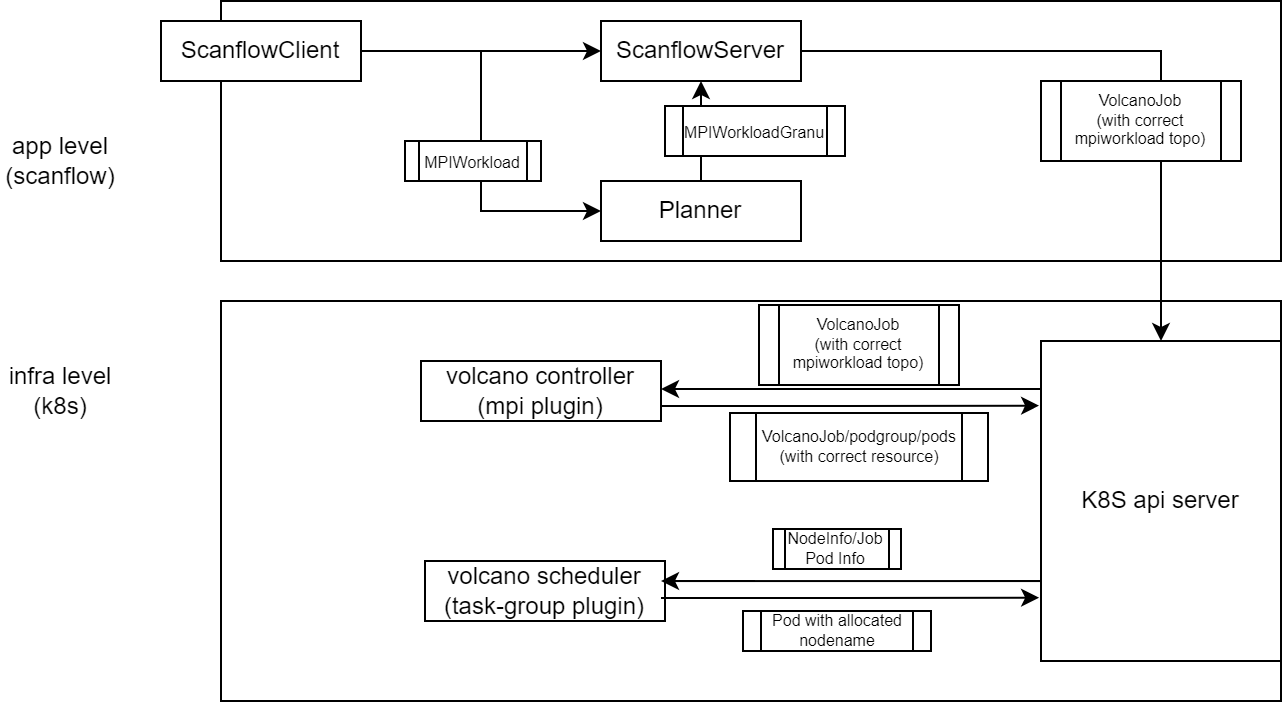

In [7]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/mpi/imp.png", width=1000, height=400)

In [8]:
import pandas as pd
import glob
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

import numpy as np
import matplotlib.pyplot as plt
# include if using a Jupyter notebook
# %matplotlib inline

In [9]:
def newWorkflow(i, benchmark, expstr, nTasks, nNodes, plugins, characteristic):
    #mpi workloads
    mpi = client.ScanflowMPIWorkload(name=f"{benchmark}",
                                      mainfile=f"{benchmark}-{expstr}.yaml",
                                      nTasks=nTasks,
                                      nNodes=nNodes,
                                      plugins=plugins,
                                      characteristic=characteristic)
    #workflow
    workflow = client.ScanflowWorkflow(type='mpi',
                                       name=f"{benchmark}-{i}",
                                       nodes=[mpi],
                                       output_dir = "/opt/results")
    return workflow

async def runWorkflow(i, build_app):
    return await deployerClient.run_workflow(app_name='mpi', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[i])

async def runAgentWorkflow(i, build_app):
#     return await deployerClient.run_workflow(app_name='mpi', 
#                                   team_name='dataengineer',
#                                   workflow = build_app.workflows[i])
    return await deployerClient1.run_autoconfig_workflow(app_name='mpi', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[i])
    
async def deleteWorkflow(i, build_app):
    return await deployerClient.delete_workflow(app_name='mpi', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[i])

In [10]:
from kubernetes import client as k8sclient
from kubernetes import config, utils
config.load_kube_config(config_file="/gpfs/bsc_home/xpliu/.kube/config")

def get_volcanoJob(namespace, name):
        api_client = k8sclient.CustomObjectsApi()
        try:
            return api_client.get_namespaced_custom_object(
                "batch.volcano.sh",
                "v1alpha1",
                namespace,
                "jobs",
                name,
            )
        except k8sclient.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the vj workflow: %s\n" % e)

def get_vjstatus(namespace, name):
        api_client = k8sclient.CustomObjectsApi()
        try:
            response = api_client.get_namespaced_custom_object(
                "batch.volcano.sh",
                "v1alpha1",
                namespace,
                "jobs",
                name,
            )
            return response['status']
        except k8sclient.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the vj workflow: %s\n" % e)
            
def get_vjstate(namespace, name):
        api_client = k8sclient.CustomObjectsApi()
        try:
            response = api_client.get_namespaced_custom_object(
                "batch.volcano.sh",
                "v1alpha1",
                namespace,
                "jobs",
                name,
            )
            return response['status']['state']['phase']
        except k8sclient.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the vj workflow: %s\n" % e)
            
# def get_vjduration(namespace, name):
#         api_client = client.CustomObjectsApi()
#         try:
#             response = api_client.get_namespaced_custom_object(
#                 "batch.volcano.sh",
#                 "v1alpha1",
#                 namespace,
#                 "jobs",
#                 name,
#             )
#             if response['status']['state']['phase']=='Completed':
#                 return response['status']['runningDuration']
#             else:
#                 raise Exception("vj workflow: %s is not completed.\n" % e)
#         except client.api_client.rest.ApiException as e:
#             raise Exception("Exception when getting the vj workflow: %s\n" % e)
            
# def get_conditions(namespace, name):
#         api_client = client.CustomObjectsApi()
#         try:
#             response = api_client.get_namespaced_custom_object(
#                 "batch.volcano.sh",
#                 "v1alpha1",
#                 namespace,
#                 "jobs",
#                 name,
#             )
#             if response['status']['state']['phase']=='Completed':
#                 return response['status']['conditions']
#             else:
#                 raise Exception("vj workflow: %s is not completed.\n" % e)
#         except client.api_client.rest.ApiException as e:
#             raise Exception("Exception when getting the vj workflow: %s\n" % e)



In [11]:
def get_pvc(namespace, name):
        api_client = k8sclient.CoreV1Api()
        try:
            response = api_client.read_namespaced_persistent_volume_claim(
                namespace = namespace,
                name = name,
            )
#             print(type(response))
#             print(response.spec.volume_name)
            return response.spec.volume_name
        except k8sclient.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the pvc: %s\n" % e)

def get_pv(name):
        api_client = k8sclient.CoreV1Api()
        try:
            response = api_client.read_persistent_volume(
                name = name,
            )
#             print(type(response))
            print(response.spec.host_path.path)
            return response.spec.host_path.path
        except k8sclient.api_client.rest.ApiException as e:
            raise Exception("Exception when getting the pv: %s\n" % e)
            
def get_outputdir(namespace, name):
    volume_name = get_pvc(namespace, name)
    path = get_pv(volume_name)
    return path

In [12]:
# get_pvc("scanflow-mpi-dataengineer", "hpccstream-9")
# get_pv("hpccstream-9")

In [13]:
# from scipy.stats import poisson
from collections import Counter

def gen_starttime(starttimelist, k):
    #generate random values from Poisson distribution with mean=mu and sample size=size
#     starttimelist = poisson.rvs(mu=10, size=totalapp)
#     writeTimePossion(f"exp2-timepossion-{k}", starttimelist)
#     print(starttimelist)
    count = Counter(starttimelist)
    print(count)
    return count

In [14]:
import csv
import subprocess

header = ['benchmark','times','nTasks','nNodes','nWorkers',
          'Pending','Running','Completing','Completed',
          'duration','performance']

def get_conditionTime(conditions, status):
    for condition in conditions:
        if condition['status'] == status:
            return condition['lastTransitionTime']
    return None
   
def get_performanceflag(benchmark):
    return {
        "hpccfft": "AVGMPIFFT_Gflops",
        "hpccdgemm": "AVGStarDGEMM_Gflops",
        "hpccptrans": "PTRANS_GBs",
        "hpccrandomringbw": "AVGRandomlyOrderedRingBandwidth_GBytes",
        "hpccrandomringlat": "AVGRandomlyOrderedRingLatency_usec",
        "hpccrandomaccess": "AVGMPIRandomAccess_GUPs",
        "hpccstream": "AVGStarSTREAM_Triad",
        "nasep":"\"Mop/s/process\"",
        "minife":"\"Total CG Mflops\"",
#         "nasep":"\"Time in seconds\"",
    }[benchmark]

def writeTimePossion(filename, starttimelist):
    with open(f"{filename}.csv", "w", encoding="UTF8") as f:
            writer = csv.writer(f)
            writer.writerow([0,1,2,3,4,5,6,7,8,9,
                            10,11,12,13,14,15,16,17,18,19,
                            20,21,22,23,24,25,26,27,28,29,
                            30,31,32,33,34,35,36,37,38,39,
                            40,41,42,43,44,45,46,47,48,49,
                            50,51,52,53,54,55,56,57,58,59])
            writer.writerow(starttimelist)

def writeCSVExp1(filename, namespace, workflowname, benchmark, nTasks, nNodes):
    vjstatus = get_vjstatus(namespace,workflowname)
    conditions = vjstatus['conditions']
    duration = vjstatus['runningDuration']
    nWorkers = vjstatus['minAvailable'] - 1
    
#     dont use randomring as first
    if benchmark == "hpccrandomring":
        for benchmark in ["hpccrandomringbw"]:
            performancestr = get_performanceflag(benchmark)
            performance = subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F'=' '{}'"
                                    .format(performancestr, get_outputdir(namespace, workflowname),"{print $2}"))
            print(f"{performancestr},{performance}")

            with open(f"{filename}.csv", "a", encoding="UTF8") as far:
                writer = csv.writer(far)
                writer.writerow([benchmark, workflowname.split("-")[1], nTasks, nNodes, nWorkers,
                                get_conditionTime(conditions, "Pending"),
                                get_conditionTime(conditions, "Running"),
                                get_conditionTime(conditions, "Completing"),
                                get_conditionTime(conditions, "Completed"),
                                duration, performance])
    else:
        performancestr = get_performanceflag(benchmark)
        if benchmark == "minife":
            performance = subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F':' '{}'"
                                .format(performancestr, get_outputdir(namespace, workflowname),"{print $2}"))
        else:
            performance = subprocess.getoutput("grep {} {}/hpccoutf.txt | awk -F'=' '{}'"
                                .format(performancestr, get_outputdir(namespace, workflowname),"{print $2}"))
        print(f"{performancestr},{performance}")

        fileexist = os.path.isfile(f"{filename}.csv")
        if fileexist:
            with open(f"{filename}.csv", "a", encoding="UTF8") as fa:
                writer = csv.writer(fa)
                writer.writerow([benchmark, workflowname.split("-")[1], nTasks, nNodes, nWorkers,
                                get_conditionTime(conditions, "Pending"),
                                get_conditionTime(conditions, "Running"),
                                get_conditionTime(conditions, "Completing"),
                                get_conditionTime(conditions, "Completed"),
                                duration, performance])
        else:
            with open(f"{filename}.csv", "w", encoding="UTF8") as f:
                writer = csv.writer(f)
                writer.writerow(header)
                writer.writerow([benchmark, workflowname.split("-")[1], nTasks, nNodes, nWorkers,
                                get_conditionTime(conditions, "Pending"),
                                get_conditionTime(conditions, "Running"),
                                get_conditionTime(conditions, "Completing"),
                                get_conditionTime(conditions, "Completed"),
                                duration, performance])
        

In [15]:
def get_parameters(scenario, times):
    df = pd.read_csv(f"exp2-parameters/exp2parametersS{scenario}-{times}.csv",sep=',' , index_col=None, header=0)
#     print(df)
    df = df.sort_values(by='starttime')

    pd.set_option('display.max_columns', None)
    print(df)
    return df

In [16]:
# get_parameters(1, 0)

1. Exp2: 4 nodes - X10 times
         metrics: workloads performance, workloads complete time, 
                  scheduler workload throughput, scheduler latency,
                  node resource utilization
         scenario
           baseline: app(16 tasks, 1-4 nodes) -> 1-4 worker
           granularity-aware containers: app(16 tasks, 1-8 nodes) -> 1-4 workers or 2-16 workers
         workloads:
           starttime in possion, 
           16 tasks fixed,
           nodes 1-4 random,
           app hpcc each 10, in total 60
         changes:
           adjust the percentage of hpcc network workloads in total workloads.
           
    (conclusion: 
    1. granularity-aware deploy better in total workloads complete time, better scheduler workload throughput and better node resource utilization
    2. reduce the percentage of hpcc network workloads could see more explict results)
         

In [17]:
def get_build_app(times, sce, parameter):
    #planner
    planner = client.ScanflowAgent(name='planner',
                                  template='planner',
                                  dockerfile='Dockerfile_fortest')
    workflows = []
    exp2parameters = get_parameters(parameter, times)
    
    starttimedict = gen_starttime(exp2parameters['starttime'], times)
    
    for i in range(len(exp2parameters)):
#     for i in range(3):
        parameter = exp2parameters.iloc[i]
        if sce == "baseline":
            workflows.append(
            newWorkflow(int(parameter.times), parameter.benchmark, 
                        f"exp2-{sce}", int(parameter.nTasks), int(parameter.nNodes), None, parameter.characteristic))
        elif sce == "scale":
            workflows.append(
            newWorkflow(int(parameter.times), parameter.benchmark, 
                        f"exp2-{sce}", int(parameter.nTasks), int(parameter.nNodes), ['scale'], parameter.characteristic))
        elif sce == "granularity":
            workflows.append(
            newWorkflow(int(parameter.times), parameter.benchmark, 
                        f"exp2-{sce}", int(parameter.nTasks), int(parameter.nNodes), ['granularity'], parameter.characteristic))
        else:
            print("unknown scenario")
    
    print(f"workflow length: {len(workflows)}")
    
    
    
    app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=workflows,
                                 agents=[planner])
    # dic = app.to_dict()
    build_app = client.build_ScanflowApplication(app = app, trackerPort=46672)
    # build_app.to_dict()
    return build_app, starttimedict

In [18]:
# print(get_build_app(0, "granularity"))

In [33]:
# Exp2-baseline

# for k in range(10):  #10 times
for k in range(1):  #10 times
    print(k)
#     for sce in ["baseline", "granularity"]:
    for sce in ["granularity"]:
        workloads, starttimedict = get_build_app(k, sce, 4)
#         await runAgentWorkflow(1, workloads)
        
        deployed = 0
        for i in range(1200): #60 mins
            if starttimedict.get(i) is not None:
                nWorkflows = starttimedict.get(i)
                print(f"time: {i}min, start: {nWorkflows}")
                for j in range(nWorkflows):
                    index = deployed
                    await runAgentWorkflow(index, workloads)
                    print(f"runworkflow: {index}, {workloads.workflows[index].name}")
                    deployed = deployed +1
            else:
                print(f"time: {i}min, start: 0")
            time.sleep (1)
            
#         get_results(k, sce, deployed)

14-Jun-22 16:02:58 -  INFO - Building image 172.30.0.49:5000/planner-agent
14-Jun-22 16:02:58 -  INFO - workflow hpccrandomring-2: {'name': 'hpccrandomring-2', 'nodes': [{'name': 'hpccrandomring', 'node_type': 'mpi', 'mainfile': 'hpccrandomring-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccrandomring-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano

0
    index       benchmark  times  nTasks  nNodes  starttime characteristic
13     13  hpccrandomring      2      16       1          0        network
16     16       hpccdgemm      1      16       4         42            cpu
1       1      hpccstream      0      16       4        154         memory
11     11          minife      3      16       4        195            cpu
19     19         hpccfft      1      16       1        255        network
5       5          minife      2      16       4        272            cpu
14     14      hpccstream      3      16       4        385         memory
6       6  hpccrandomring      0      16       1        472        network
15     15         hpccfft      0      16       1        498        network
0       0       hpccdgemm      2      16       4        553            cpu
4       4      hpccstream      2      16       4        584         memory
18     18  hpccrandomring      3      16       1        612        network
7       7       hpccdge

14-Jun-22 16:02:58 -  INFO - sensors_run_autoconfig_workflow received


runworkflow: 0, hpccrandomring-2
time: 1min, start: 0
time: 2min, start: 0
time: 3min, start: 0
time: 4min, start: 0
time: 5min, start: 0
time: 6min, start: 0
time: 7min, start: 0
time: 8min, start: 0
time: 9min, start: 0
time: 10min, start: 0
time: 11min, start: 0
time: 12min, start: 0
time: 13min, start: 0
time: 14min, start: 0
time: 15min, start: 0
time: 16min, start: 0
time: 17min, start: 0
time: 18min, start: 0
time: 19min, start: 0
time: 20min, start: 0
time: 21min, start: 0
time: 22min, start: 0
time: 23min, start: 0
time: 24min, start: 0
time: 25min, start: 0
time: 26min, start: 0
time: 27min, start: 0
time: 28min, start: 0
time: 29min, start: 0
time: 30min, start: 0
time: 31min, start: 0
time: 32min, start: 0
time: 33min, start: 0
time: 34min, start: 0
time: 35min, start: 0
time: 36min, start: 0
time: 37min, start: 0
time: 38min, start: 0
time: 39min, start: 0
time: 40min, start: 0
time: 41min, start: 0


14-Jun-22 16:03:40 -  INFO - workflow hpccdgemm-1: {'name': 'hpccdgemm-1', 'nodes': [{'name': 'hpccdgemm', 'node_type': 'mpi', 'mainfile': 'hpccdgemm-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccdgemm-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done

time: 42min, start: 1
runworkflow: 1, hpccdgemm-1
time: 43min, start: 0
time: 44min, start: 0
time: 45min, start: 0
time: 46min, start: 0
time: 47min, start: 0
time: 48min, start: 0
time: 49min, start: 0
time: 50min, start: 0
time: 51min, start: 0
time: 52min, start: 0
time: 53min, start: 0
time: 54min, start: 0
time: 55min, start: 0
time: 56min, start: 0
time: 57min, start: 0
time: 58min, start: 0
time: 59min, start: 0
time: 60min, start: 0
time: 61min, start: 0
time: 62min, start: 0
time: 63min, start: 0
time: 64min, start: 0
time: 65min, start: 0
time: 66min, start: 0
time: 67min, start: 0
time: 68min, start: 0
time: 69min, start: 0
time: 70min, start: 0
time: 71min, start: 0
time: 72min, start: 0
time: 73min, start: 0
time: 74min, start: 0
time: 75min, start: 0
time: 76min, start: 0
time: 77min, start: 0
time: 78min, start: 0
time: 79min, start: 0
time: 80min, start: 0
time: 81min, start: 0
time: 82min, start: 0
time: 83min, start: 0
time: 84min, start: 0
time: 85min, start: 0
time

14-Jun-22 16:05:32 -  INFO - workflow hpccstream-0: {'name': 'hpccstream-0', 'nodes': [{'name': 'hpccstream', 'node_type': 'mpi', 'mainfile': 'hpccstream-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'memory', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccstream-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep

time: 154min, start: 1
runworkflow: 2, hpccstream-0
time: 155min, start: 0
time: 156min, start: 0
time: 157min, start: 0
time: 158min, start: 0
time: 159min, start: 0
time: 160min, start: 0
time: 161min, start: 0
time: 162min, start: 0
time: 163min, start: 0
time: 164min, start: 0
time: 165min, start: 0
time: 166min, start: 0
time: 167min, start: 0
time: 168min, start: 0
time: 169min, start: 0
time: 170min, start: 0
time: 171min, start: 0
time: 172min, start: 0
time: 173min, start: 0
time: 174min, start: 0
time: 175min, start: 0
time: 176min, start: 0
time: 177min, start: 0
time: 178min, start: 0
time: 179min, start: 0
time: 180min, start: 0
time: 181min, start: 0
time: 182min, start: 0
time: 183min, start: 0
time: 184min, start: 0
time: 185min, start: 0
time: 186min, start: 0
time: 187min, start: 0
time: 188min, start: 0
time: 189min, start: 0
time: 190min, start: 0
time: 191min, start: 0
time: 192min, start: 0
time: 193min, start: 0
time: 194min, start: 0


14-Jun-22 16:06:13 -  INFO - workflow minife-3: {'name': 'minife-3', 'nodes': [{'name': 'minife', 'node_type': 'mpi', 'mainfile': 'minife-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'minife-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done\nsleep 5

time: 195min, start: 1
runworkflow: 3, minife-3
time: 196min, start: 0
time: 197min, start: 0
time: 198min, start: 0
time: 199min, start: 0
time: 200min, start: 0
time: 201min, start: 0
time: 202min, start: 0
time: 203min, start: 0
time: 204min, start: 0
time: 205min, start: 0
time: 206min, start: 0
time: 207min, start: 0
time: 208min, start: 0
time: 209min, start: 0
time: 210min, start: 0
time: 211min, start: 0
time: 212min, start: 0
time: 213min, start: 0
time: 214min, start: 0
time: 215min, start: 0
time: 216min, start: 0
time: 217min, start: 0
time: 218min, start: 0
time: 219min, start: 0
time: 220min, start: 0
time: 221min, start: 0
time: 222min, start: 0
time: 223min, start: 0
time: 224min, start: 0
time: 225min, start: 0
time: 226min, start: 0
time: 227min, start: 0
time: 228min, start: 0
time: 229min, start: 0
time: 230min, start: 0
time: 231min, start: 0
time: 232min, start: 0
time: 233min, start: 0
time: 234min, start: 0
time: 235min, start: 0
time: 236min, start: 0
time: 237

14-Jun-22 16:07:13 -  INFO - workflow hpccfft-1: {'name': 'hpccfft-1', 'nodes': [{'name': 'hpccfft', 'node_type': 'mpi', 'mainfile': 'hpccfft-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccfft-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done

time: 255min, start: 1
runworkflow: 4, hpccfft-1
time: 256min, start: 0
time: 257min, start: 0
time: 258min, start: 0
time: 259min, start: 0
time: 260min, start: 0
time: 261min, start: 0
time: 262min, start: 0
time: 263min, start: 0
time: 264min, start: 0
time: 265min, start: 0
time: 266min, start: 0
time: 267min, start: 0
time: 268min, start: 0
time: 269min, start: 0
time: 270min, start: 0
time: 271min, start: 0


14-Jun-22 16:07:31 -  INFO - workflow minife-2: {'name': 'minife-2', 'nodes': [{'name': 'minife', 'node_type': 'mpi', 'mainfile': 'minife-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'minife-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done\nsleep 5

time: 272min, start: 1
runworkflow: 5, minife-2
time: 273min, start: 0
time: 274min, start: 0
time: 275min, start: 0
time: 276min, start: 0
time: 277min, start: 0
time: 278min, start: 0
time: 279min, start: 0
time: 280min, start: 0
time: 281min, start: 0
time: 282min, start: 0
time: 283min, start: 0
time: 284min, start: 0
time: 285min, start: 0
time: 286min, start: 0
time: 287min, start: 0
time: 288min, start: 0
time: 289min, start: 0
time: 290min, start: 0
time: 291min, start: 0
time: 292min, start: 0
time: 293min, start: 0
time: 294min, start: 0
time: 295min, start: 0
time: 296min, start: 0
time: 297min, start: 0
time: 298min, start: 0
time: 299min, start: 0
time: 300min, start: 0
time: 301min, start: 0
time: 302min, start: 0
time: 303min, start: 0
time: 304min, start: 0
time: 305min, start: 0
time: 306min, start: 0
time: 307min, start: 0
time: 308min, start: 0
time: 309min, start: 0
time: 310min, start: 0
time: 311min, start: 0
time: 312min, start: 0
time: 313min, start: 0
time: 314

14-Jun-22 16:09:24 -  INFO - workflow hpccstream-3: {'name': 'hpccstream-3', 'nodes': [{'name': 'hpccstream', 'node_type': 'mpi', 'mainfile': 'hpccstream-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'memory', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccstream-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep

time: 385min, start: 1
runworkflow: 6, hpccstream-3
time: 386min, start: 0
time: 387min, start: 0
time: 388min, start: 0
time: 389min, start: 0
time: 390min, start: 0
time: 391min, start: 0
time: 392min, start: 0
time: 393min, start: 0
time: 394min, start: 0
time: 395min, start: 0
time: 396min, start: 0
time: 397min, start: 0
time: 398min, start: 0
time: 399min, start: 0
time: 400min, start: 0
time: 401min, start: 0
time: 402min, start: 0
time: 403min, start: 0
time: 404min, start: 0
time: 405min, start: 0
time: 406min, start: 0
time: 407min, start: 0
time: 408min, start: 0
time: 409min, start: 0
time: 410min, start: 0
time: 411min, start: 0
time: 412min, start: 0
time: 413min, start: 0
time: 414min, start: 0
time: 415min, start: 0
time: 416min, start: 0
time: 417min, start: 0
time: 418min, start: 0
time: 419min, start: 0
time: 420min, start: 0
time: 421min, start: 0
time: 422min, start: 0
time: 423min, start: 0
time: 424min, start: 0
time: 425min, start: 0
time: 426min, start: 0
time:

14-Jun-22 16:10:51 -  INFO - workflow hpccrandomring-0: {'name': 'hpccrandomring-0', 'nodes': [{'name': 'hpccrandomring', 'node_type': 'mpi', 'mainfile': 'hpccrandomring-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccrandomring-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; d

time: 472min, start: 1
runworkflow: 7, hpccrandomring-0
time: 473min, start: 0
time: 474min, start: 0
time: 475min, start: 0
time: 476min, start: 0
time: 477min, start: 0
time: 478min, start: 0
time: 479min, start: 0
time: 480min, start: 0
time: 481min, start: 0
time: 482min, start: 0
time: 483min, start: 0
time: 484min, start: 0
time: 485min, start: 0
time: 486min, start: 0
time: 487min, start: 0
time: 488min, start: 0
time: 489min, start: 0
time: 490min, start: 0
time: 491min, start: 0
time: 492min, start: 0
time: 493min, start: 0
time: 494min, start: 0
time: 495min, start: 0
time: 496min, start: 0
time: 497min, start: 0


14-Jun-22 16:11:17 -  INFO - workflow hpccfft-0: {'name': 'hpccfft-0', 'nodes': [{'name': 'hpccfft', 'node_type': 'mpi', 'mainfile': 'hpccfft-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccfft-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done

time: 498min, start: 1
runworkflow: 8, hpccfft-0
time: 499min, start: 0
time: 500min, start: 0
time: 501min, start: 0
time: 502min, start: 0
time: 503min, start: 0
time: 504min, start: 0
time: 505min, start: 0
time: 506min, start: 0
time: 507min, start: 0
time: 508min, start: 0
time: 509min, start: 0
time: 510min, start: 0
time: 511min, start: 0
time: 512min, start: 0
time: 513min, start: 0
time: 514min, start: 0
time: 515min, start: 0
time: 516min, start: 0
time: 517min, start: 0
time: 518min, start: 0
time: 519min, start: 0
time: 520min, start: 0
time: 521min, start: 0
time: 522min, start: 0
time: 523min, start: 0
time: 524min, start: 0
time: 525min, start: 0
time: 526min, start: 0
time: 527min, start: 0
time: 528min, start: 0
time: 529min, start: 0
time: 530min, start: 0
time: 531min, start: 0
time: 532min, start: 0
time: 533min, start: 0
time: 534min, start: 0
time: 535min, start: 0
time: 536min, start: 0
time: 537min, start: 0
time: 538min, start: 0
time: 539min, start: 0
time: 54

14-Jun-22 16:12:12 -  INFO - workflow hpccdgemm-2: {'name': 'hpccdgemm-2', 'nodes': [{'name': 'hpccdgemm', 'node_type': 'mpi', 'mainfile': 'hpccdgemm-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccdgemm-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done

time: 553min, start: 1
runworkflow: 9, hpccdgemm-2
time: 554min, start: 0
time: 555min, start: 0
time: 556min, start: 0
time: 557min, start: 0
time: 558min, start: 0
time: 559min, start: 0
time: 560min, start: 0
time: 561min, start: 0
time: 562min, start: 0
time: 563min, start: 0
time: 564min, start: 0
time: 565min, start: 0
time: 566min, start: 0
time: 567min, start: 0
time: 568min, start: 0
time: 569min, start: 0
time: 570min, start: 0
time: 571min, start: 0
time: 572min, start: 0
time: 573min, start: 0
time: 574min, start: 0
time: 575min, start: 0
time: 576min, start: 0
time: 577min, start: 0
time: 578min, start: 0
time: 579min, start: 0
time: 580min, start: 0
time: 581min, start: 0
time: 582min, start: 0
time: 583min, start: 0


14-Jun-22 16:12:44 -  INFO - workflow hpccstream-2: {'name': 'hpccstream-2', 'nodes': [{'name': 'hpccstream', 'node_type': 'mpi', 'mainfile': 'hpccstream-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'memory', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccstream-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep

time: 584min, start: 1
runworkflow: 10, hpccstream-2
time: 585min, start: 0
time: 586min, start: 0
time: 587min, start: 0
time: 588min, start: 0
time: 589min, start: 0
time: 590min, start: 0
time: 591min, start: 0
time: 592min, start: 0
time: 593min, start: 0
time: 594min, start: 0
time: 595min, start: 0
time: 596min, start: 0
time: 597min, start: 0
time: 598min, start: 0
time: 599min, start: 0
time: 600min, start: 0
time: 601min, start: 0
time: 602min, start: 0
time: 603min, start: 0
time: 604min, start: 0
time: 605min, start: 0
time: 606min, start: 0
time: 607min, start: 0
time: 608min, start: 0
time: 609min, start: 0
time: 610min, start: 0
time: 611min, start: 0


14-Jun-22 16:13:12 -  INFO - workflow hpccrandomring-3: {'name': 'hpccrandomring-3', 'nodes': [{'name': 'hpccrandomring', 'node_type': 'mpi', 'mainfile': 'hpccrandomring-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccrandomring-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; d

time: 612min, start: 1
runworkflow: 11, hpccrandomring-3
time: 613min, start: 0
time: 614min, start: 0
time: 615min, start: 0
time: 616min, start: 0
time: 617min, start: 0
time: 618min, start: 0
time: 619min, start: 0
time: 620min, start: 0
time: 621min, start: 0
time: 622min, start: 0
time: 623min, start: 0
time: 624min, start: 0
time: 625min, start: 0
time: 626min, start: 0
time: 627min, start: 0
time: 628min, start: 0
time: 629min, start: 0
time: 630min, start: 0
time: 631min, start: 0
time: 632min, start: 0
time: 633min, start: 0
time: 634min, start: 0
time: 635min, start: 0
time: 636min, start: 0
time: 637min, start: 0
time: 638min, start: 0
time: 639min, start: 0
time: 640min, start: 0
time: 641min, start: 0
time: 642min, start: 0
time: 643min, start: 0
time: 644min, start: 0
time: 645min, start: 0
time: 646min, start: 0
time: 647min, start: 0
time: 648min, start: 0
time: 649min, start: 0
time: 650min, start: 0


14-Jun-22 16:13:51 -  INFO - workflow hpccdgemm-3: {'name': 'hpccdgemm-3', 'nodes': [{'name': 'hpccdgemm', 'node_type': 'mpi', 'mainfile': 'hpccdgemm-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccdgemm-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done

time: 651min, start: 1


14-Jun-22 16:13:52 -  INFO - sensors_run_autoconfig_workflow received


runworkflow: 12, hpccdgemm-3
time: 652min, start: 0
time: 653min, start: 0
time: 654min, start: 0
time: 655min, start: 0
time: 656min, start: 0
time: 657min, start: 0
time: 658min, start: 0
time: 659min, start: 0
time: 660min, start: 0
time: 661min, start: 0
time: 662min, start: 0
time: 663min, start: 0
time: 664min, start: 0
time: 665min, start: 0
time: 666min, start: 0
time: 667min, start: 0
time: 668min, start: 0
time: 669min, start: 0
time: 670min, start: 0
time: 671min, start: 0
time: 672min, start: 0
time: 673min, start: 0
time: 674min, start: 0
time: 675min, start: 0
time: 676min, start: 0
time: 677min, start: 0
time: 678min, start: 0
time: 679min, start: 0
time: 680min, start: 0
time: 681min, start: 0
time: 682min, start: 0
time: 683min, start: 0


14-Jun-22 16:14:25 -  INFO - workflow hpccfft-3: {'name': 'hpccfft-3', 'nodes': [{'name': 'hpccfft', 'node_type': 'mpi', 'mainfile': 'hpccfft-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccfft-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done

time: 684min, start: 1
runworkflow: 13, hpccfft-3
time: 685min, start: 0
time: 686min, start: 0
time: 687min, start: 0
time: 688min, start: 0
time: 689min, start: 0
time: 690min, start: 0
time: 691min, start: 0
time: 692min, start: 0
time: 693min, start: 0
time: 694min, start: 0
time: 695min, start: 0
time: 696min, start: 0
time: 697min, start: 0
time: 698min, start: 0
time: 699min, start: 0
time: 700min, start: 0
time: 701min, start: 0
time: 702min, start: 0
time: 703min, start: 0
time: 704min, start: 0
time: 705min, start: 0
time: 706min, start: 0
time: 707min, start: 0


14-Jun-22 16:14:49 -  INFO - workflow minife-0: {'name': 'minife-0', 'nodes': [{'name': 'minife', 'node_type': 'mpi', 'mainfile': 'minife-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'minife-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done\nsleep 5

time: 708min, start: 1
runworkflow: 14, minife-0
time: 709min, start: 0
time: 710min, start: 0
time: 711min, start: 0
time: 712min, start: 0
time: 713min, start: 0
time: 714min, start: 0
time: 715min, start: 0
time: 716min, start: 0
time: 717min, start: 0
time: 718min, start: 0
time: 719min, start: 0
time: 720min, start: 0
time: 721min, start: 0
time: 722min, start: 0
time: 723min, start: 0
time: 724min, start: 0
time: 725min, start: 0
time: 726min, start: 0
time: 727min, start: 0
time: 728min, start: 0
time: 729min, start: 0
time: 730min, start: 0
time: 731min, start: 0
time: 732min, start: 0
time: 733min, start: 0
time: 734min, start: 0
time: 735min, start: 0
time: 736min, start: 0
time: 737min, start: 0
time: 738min, start: 0
time: 739min, start: 0
time: 740min, start: 0
time: 741min, start: 0
time: 742min, start: 0
time: 743min, start: 0
time: 744min, start: 0
time: 745min, start: 0
time: 746min, start: 0


14-Jun-22 16:15:28 -  INFO - workflow hpccrandomring-1: {'name': 'hpccrandomring-1', 'nodes': [{'name': 'hpccrandomring', 'node_type': 'mpi', 'mainfile': 'hpccrandomring-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccrandomring-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; d

time: 747min, start: 1
runworkflow: 15, hpccrandomring-1
time: 748min, start: 0
time: 749min, start: 0
time: 750min, start: 0
time: 751min, start: 0
time: 752min, start: 0
time: 753min, start: 0
time: 754min, start: 0
time: 755min, start: 0
time: 756min, start: 0
time: 757min, start: 0
time: 758min, start: 0
time: 759min, start: 0
time: 760min, start: 0
time: 761min, start: 0
time: 762min, start: 0
time: 763min, start: 0
time: 764min, start: 0
time: 765min, start: 0
time: 766min, start: 0
time: 767min, start: 0
time: 768min, start: 0
time: 769min, start: 0
time: 770min, start: 0
time: 771min, start: 0
time: 772min, start: 0
time: 773min, start: 0
time: 774min, start: 0
time: 775min, start: 0
time: 776min, start: 0
time: 777min, start: 0
time: 778min, start: 0
time: 779min, start: 0
time: 780min, start: 0
time: 781min, start: 0
time: 782min, start: 0
time: 783min, start: 0
time: 784min, start: 0
time: 785min, start: 0
time: 786min, start: 0
time: 787min, start: 0
time: 788min, start: 0


14-Jun-22 16:16:31 -  INFO - workflow minife-1: {'name': 'minife-1', 'nodes': [{'name': 'minife', 'node_type': 'mpi', 'mainfile': 'minife-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'minife-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done\nsleep 5

time: 810min, start: 1
runworkflow: 16, minife-1
time: 811min, start: 0
time: 812min, start: 0
time: 813min, start: 0
time: 814min, start: 0
time: 815min, start: 0
time: 816min, start: 0
time: 817min, start: 0
time: 818min, start: 0
time: 819min, start: 0
time: 820min, start: 0
time: 821min, start: 0
time: 822min, start: 0
time: 823min, start: 0
time: 824min, start: 0
time: 825min, start: 0
time: 826min, start: 0
time: 827min, start: 0
time: 828min, start: 0
time: 829min, start: 0
time: 830min, start: 0
time: 831min, start: 0
time: 832min, start: 0
time: 833min, start: 0
time: 834min, start: 0
time: 835min, start: 0
time: 836min, start: 0
time: 837min, start: 0
time: 838min, start: 0
time: 839min, start: 0
time: 840min, start: 0
time: 841min, start: 0
time: 842min, start: 0
time: 843min, start: 0
time: 844min, start: 0
time: 845min, start: 0
time: 846min, start: 0
time: 847min, start: 0
time: 848min, start: 0
time: 849min, start: 0
time: 850min, start: 0
time: 851min, start: 0
time: 85

14-Jun-22 16:17:15 -  INFO - workflow hpccstream-1: {'name': 'hpccstream-1', 'nodes': [{'name': 'hpccstream', 'node_type': 'mpi', 'mainfile': 'hpccstream-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'memory', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccstream-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep

time: 853min, start: 1
runworkflow: 17, hpccstream-1
time: 854min, start: 0
time: 855min, start: 0
time: 856min, start: 0
time: 857min, start: 0
time: 858min, start: 0
time: 859min, start: 0
time: 860min, start: 0
time: 861min, start: 0
time: 862min, start: 0
time: 863min, start: 0
time: 864min, start: 0
time: 865min, start: 0
time: 866min, start: 0
time: 867min, start: 0
time: 868min, start: 0
time: 869min, start: 0
time: 870min, start: 0
time: 871min, start: 0
time: 872min, start: 0
time: 873min, start: 0
time: 874min, start: 0
time: 875min, start: 0
time: 876min, start: 0
time: 877min, start: 0
time: 878min, start: 0
time: 879min, start: 0
time: 880min, start: 0
time: 881min, start: 0
time: 882min, start: 0
time: 883min, start: 0
time: 884min, start: 0
time: 885min, start: 0
time: 886min, start: 0
time: 887min, start: 0
time: 888min, start: 0
time: 889min, start: 0
time: 890min, start: 0
time: 891min, start: 0
time: 892min, start: 0
time: 893min, start: 0
time: 894min, start: 0
time

14-Jun-22 16:17:58 -  INFO - workflow hpccdgemm-0: {'name': 'hpccdgemm-0', 'nodes': [{'name': 'hpccdgemm', 'node_type': 'mpi', 'mainfile': 'hpccdgemm-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'cpu', 'nTasks': 16, 'nNodes': 4, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccdgemm-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done

time: 896min, start: 1
runworkflow: 18, hpccdgemm-0
time: 897min, start: 0
time: 898min, start: 0
time: 899min, start: 0
time: 900min, start: 0
time: 901min, start: 0
time: 902min, start: 0
time: 903min, start: 0
time: 904min, start: 0
time: 905min, start: 0
time: 906min, start: 0
time: 907min, start: 0
time: 908min, start: 0
time: 909min, start: 0
time: 910min, start: 0
time: 911min, start: 0
time: 912min, start: 0
time: 913min, start: 0
time: 914min, start: 0
time: 915min, start: 0
time: 916min, start: 0
time: 917min, start: 0
time: 918min, start: 0
time: 919min, start: 0
time: 920min, start: 0
time: 921min, start: 0
time: 922min, start: 0
time: 923min, start: 0
time: 924min, start: 0
time: 925min, start: 0
time: 926min, start: 0
time: 927min, start: 0
time: 928min, start: 0
time: 929min, start: 0
time: 930min, start: 0
time: 931min, start: 0
time: 932min, start: 0
time: 933min, start: 0
time: 934min, start: 0
time: 935min, start: 0
time: 936min, start: 0
time: 937min, start: 0
time:

14-Jun-22 16:22:29 -  INFO - workflow hpccfft-2: {'name': 'hpccfft-2', 'nodes': [{'name': 'hpccfft', 'node_type': 'mpi', 'mainfile': 'hpccfft-exp2-granularity.yaml', 'plugins': ['granularity'], 'characteristic': 'network', 'nTasks': 16, 'nNodes': 1, 'nCpusPerTask': 1, 'memoryPerTask': '5Gi', 'masterName': 'mpimaster', 'workerName': 'mpiworker', 'oversubscribe': False, 'body': {'apiVersion': 'batch.volcano.sh/v1alpha1', 'kind': 'Job', 'metadata': {'name': 'hpccfft-exp2-granularity'}, 'spec': {'schedulerName': 'volcano', 'plugins': {'ssh': [], 'svc': []}, 'tasks': [{'replicas': 1, 'name': 'mpimaster', 'policies': [{'event': 'TaskCompleted', 'action': 'CompleteJob'}], 'template': {'spec': {'nodeName': 'nxt2030', 'containers': [{'command': ['/bin/sh', '-c', 'MPI_HOST="/etc/volcano/mpi/HOSTFILE";\necho `cat ${MPI_HOST}`\nmkdir -p /var/run/sshd; /usr/sbin/sshd;\nstr=`cat /etc/volcano/mpiworker.host | tr "\\n" " "`\nfor i in $str; do until ssh $i hostname; do echo wait $i; sleep 2; done; done

time: 1167min, start: 1
runworkflow: 19, hpccfft-2
time: 1168min, start: 0
time: 1169min, start: 0
time: 1170min, start: 0
time: 1171min, start: 0
time: 1172min, start: 0
time: 1173min, start: 0
time: 1174min, start: 0
time: 1175min, start: 0
time: 1176min, start: 0
time: 1177min, start: 0
time: 1178min, start: 0
time: 1179min, start: 0
time: 1180min, start: 0
time: 1181min, start: 0
time: 1182min, start: 0
time: 1183min, start: 0
time: 1184min, start: 0
time: 1185min, start: 0
time: 1186min, start: 0
time: 1187min, start: 0
time: 1188min, start: 0
time: 1189min, start: 0
time: 1190min, start: 0
time: 1191min, start: 0
time: 1192min, start: 0
time: 1193min, start: 0
time: 1194min, start: 0
time: 1195min, start: 0
time: 1196min, start: 0
time: 1197min, start: 0
time: 1198min, start: 0
time: 1199min, start: 0


In [34]:
print(len(workloads.workflows))
print(sce)

20
granularity


In [35]:
await get_results(0, "granularity", 20)

scanflow-mpi-dataengineer, hpccrandomring-2, hpccrandomring, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccrandomring-2-output
AVGRandomlyOrderedRingBandwidth_GBytes,1.8776


14-Jun-22 16:42:33 -  INFO - delete_pvc true
14-Jun-22 16:42:33 -  INFO - delete_pv true
14-Jun-22 16:42:33 -  INFO - delete_pvc true
14-Jun-22 16:42:33 -  INFO - delete_pv true


scanflow-mpi-dataengineer, hpccdgemm-1, hpccdgemm, 16, 4
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccdgemm-1-output
AVGStarDGEMM_Gflops,36.681
scanflow-mpi-dataengineer, hpccstream-0, hpccstream, 16, 4
jobcompleted


14-Jun-22 16:42:33 -  INFO - delete_pvc true
14-Jun-22 16:42:33 -  INFO - delete_pv true


/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccstream-0-output
AVGStarSTREAM_Triad,6.63249
scanflow-mpi-dataengineer, minife-3, minife, 16, 4
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/minife-3-output


14-Jun-22 16:42:33 -  INFO - delete_pvc true
14-Jun-22 16:42:33 -  INFO - delete_pv true


"Total CG Mflops", 9726.98
scanflow-mpi-dataengineer, hpccfft-1, hpccfft, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccfft-1-output
AVGMPIFFT_Gflops,8.67418


14-Jun-22 16:42:34 -  INFO - delete_pvc true
14-Jun-22 16:42:34 -  INFO - delete_pv true
14-Jun-22 16:42:34 -  INFO - delete_pvc true
14-Jun-22 16:42:34 -  INFO - delete_pv true


scanflow-mpi-dataengineer, minife-2, minife, 16, 4
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/minife-2-output
"Total CG Mflops", 8609.87
scanflow-mpi-dataengineer, hpccstream-3, hpccstream, 16, 4
jobcompleted


14-Jun-22 16:42:34 -  INFO - delete_pvc true
14-Jun-22 16:42:34 -  INFO - delete_pv true


/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccstream-3-output
AVGStarSTREAM_Triad,5.68706
scanflow-mpi-dataengineer, hpccrandomring-0, hpccrandomring, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccrandomring-0-output


14-Jun-22 16:42:34 -  INFO - delete_pvc true
14-Jun-22 16:42:34 -  INFO - delete_pv true


AVGRandomlyOrderedRingBandwidth_GBytes,1.67854
scanflow-mpi-dataengineer, hpccfft-0, hpccfft, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccfft-0-output
AVGMPIFFT_Gflops,10.5781


14-Jun-22 16:42:34 -  INFO - delete_pvc true
14-Jun-22 16:42:34 -  INFO - delete_pv true
14-Jun-22 16:42:35 -  INFO - delete_pvc true
14-Jun-22 16:42:35 -  INFO - delete_pv true


scanflow-mpi-dataengineer, hpccdgemm-2, hpccdgemm, 16, 4
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccdgemm-2-output
AVGStarDGEMM_Gflops,36.3745
scanflow-mpi-dataengineer, hpccstream-2, hpccstream, 16, 4


14-Jun-22 16:42:35 -  INFO - delete_pvc true
14-Jun-22 16:42:35 -  INFO - delete_pv true


jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccstream-2-output
AVGStarSTREAM_Triad,3.87925
scanflow-mpi-dataengineer, hpccrandomring-3, hpccrandomring, 16, 1
jobcompleted


14-Jun-22 16:42:35 -  INFO - delete_pvc true
14-Jun-22 16:42:35 -  INFO - delete_pv true


/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccrandomring-3-output
AVGRandomlyOrderedRingBandwidth_GBytes,1.85827
scanflow-mpi-dataengineer, hpccdgemm-3, hpccdgemm, 16, 4
jobcompleted


14-Jun-22 16:42:35 -  INFO - delete_pvc true
14-Jun-22 16:42:35 -  INFO - delete_pv true


/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccdgemm-3-output
AVGStarDGEMM_Gflops,36.5695
scanflow-mpi-dataengineer, hpccfft-3, hpccfft, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccfft-3-output
AVGMPIFFT_Gflops,9.04465


14-Jun-22 16:42:35 -  INFO - delete_pvc true
14-Jun-22 16:42:35 -  INFO - delete_pv true


scanflow-mpi-dataengineer, minife-0, minife, 16, 4
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/minife-0-output
"Total CG Mflops", 10501.3


14-Jun-22 16:42:35 -  INFO - delete_pvc true
14-Jun-22 16:42:35 -  INFO - delete_pv true
14-Jun-22 16:42:36 -  INFO - delete_pvc true
14-Jun-22 16:42:36 -  INFO - delete_pv true


scanflow-mpi-dataengineer, hpccrandomring-1, hpccrandomring, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccrandomring-1-output
AVGRandomlyOrderedRingBandwidth_GBytes,1.87352
scanflow-mpi-dataengineer, minife-1, minife, 16, 4


14-Jun-22 16:42:36 -  INFO - delete_pvc true
14-Jun-22 16:42:36 -  INFO - delete_pv true


jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/minife-1-output
"Total CG Mflops", 11106.7
scanflow-mpi-dataengineer, hpccstream-1, hpccstream, 16, 4
jobcompleted


14-Jun-22 16:42:36 -  INFO - delete_pvc true
14-Jun-22 16:42:36 -  INFO - delete_pv true


/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccstream-1-output
AVGStarSTREAM_Triad,4.77655
scanflow-mpi-dataengineer, hpccdgemm-0, hpccdgemm, 16, 4
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccdgemm-0-output
AVGStarDGEMM_Gflops,38.4099


14-Jun-22 16:42:36 -  INFO - delete_pvc true
14-Jun-22 16:42:36 -  INFO - delete_pv true
14-Jun-22 16:42:36 -  INFO - delete_pvc true
14-Jun-22 16:42:36 -  INFO - delete_pv true


scanflow-mpi-dataengineer, hpccfft-2, hpccfft, 16, 1
jobcompleted
/gpfs/bsc_home/xpliu/pv/scanflow-output/hpccfft-2-output
AVGMPIFFT_Gflops,10.876


In [25]:
async def get_results(k, sce, deployed):
#     countdown = deployed
#     pass
#     check=True
#     while(check):
    for i in range(len(workloads.workflows)):
        try:
                namespace = f"scanflow-{app_name}-{team_name}"
                workflowname = workloads.workflows[i].name
                benchmark = workloads.workflows[i].nodes[0].name
                nTasks = workloads.workflows[i].nodes[0].nTasks
                nNodes = workloads.workflows[i].nodes[0].nNodes
                print(f"{namespace}, {workflowname}, {benchmark}, {nTasks}, {nNodes}")
                if get_vjstate(namespace,workflowname) == 'Completed':
                    print("jobcompleted")
                    writeCSVExp1(f"exp2-{sce}", namespace, workflowname, benchmark,
                                nTasks, nNodes)
                    await deleteWorkflow(i, workloads)
        except:
            print("wait, error")

In [21]:
workloads, starttimedict = get_build_app(0,"baseline",4)

10-May-22 10:09:01 -  INFO - Building image 172.30.0.49:5000/planner-agent


    index       benchmark  times  nTasks  nNodes  starttime characteristic
13     13  hpccrandomring      2      16       1          0        network
16     16       hpccdgemm      1      16       1         42            cpu
1       1      hpccstream      0      16       1        154         memory
11     11          minife      3      16       1        195            cpu
19     19         hpccfft      1      16       1        255        network
5       5          minife      2      16       1        272            cpu
14     14      hpccstream      3      16       1        385         memory
6       6  hpccrandomring      0      16       1        472        network
15     15         hpccfft      0      16       1        498        network
0       0       hpccdgemm      2      16       1        553            cpu
4       4      hpccstream      2      16       1        584         memory
18     18  hpccrandomring      3      16       1        612        network
7       7       hpccdgemm

In [21]:
for i in range(20):
    await deleteWorkflow(i, workloads)

14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true
14-Jun-22 11:31:35 -  INFO - delete_pvc true
14-Jun-22 11:31:35 -  INFO - delete_pv true


IndexError: list index out of range


  
### Step4: Clean scanflow environment
  
  1. delete environment
  

In [16]:
await deployerClient.clean_environment(app=build_app)

10-Mar-22 12:29:05 -  INFO - [++] Stopping agent: [planner].
10-Mar-22 12:29:05 -  INFO - delete_deployment true
10-Mar-22 12:29:05 -  INFO - delete_service true
10-Mar-22 12:29:05 -  INFO - [++] Stopping tracker: [scanflow-tracker].
10-Mar-22 12:29:05 -  INFO - delete_deployment true
10-Mar-22 12:29:05 -  INFO - delete_service true
10-Mar-22 12:29:05 -  INFO - [++]Delete tracker configmap scanflow-tracker-env
10-Mar-22 12:29:05 -  INFO - delete_configmap true
10-Mar-22 12:29:05 -  INFO - [++]Delete client configmap scanflow-client-env
10-Mar-22 12:29:05 -  INFO - delete_configmap true
10-Mar-22 12:29:05 -  INFO - [++]Delete s3 secret scanflow-secret
10-Mar-22 12:29:05 -  INFO - delete_secret true
10-Mar-22 12:29:05 -  INFO - [++]Delete rolebinding default-admin
10-Mar-22 12:29:05 -  INFO - delete_rolebinding info
10-Mar-22 12:29:05 -  INFO - [++]Delete namespace "scanflow-mpi-dataengineer"
10-Mar-22 12:29:05 -  INFO - delete_namespace true
10-Mar-22 12:29:05 -  INFO - delete_pvc true
